## Importações

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Leitura dataset

In [15]:
dataset = pd.read_csv('coverage-dataset.csv', sep=';')
dataset.head(5)

,Name,CountInput,CountLine,CountLineBlank,CountLineCode,CountLineCodeDecl,CountLineCodeExe,CountLineComment,CountOutput,CountPath,...,CyclomaticStrict.1,Essential.1,Knots.1,MaxEssentialKnots.1,MaxNesting.1,MinEssentialKnots.1,RatioCommentToCode.1,EdgeCoverage,PrimePathCoverage,Unnamed: 50
0,com.puppycrawl.tools.checkstyle.Checker.clearC...,4,8,0,5,1,2,3,1,2,...,1,1,0,0,1,0,0.05,NaN,"0,0000",NaN
1,com.puppycrawl.tools.checkstyle.DefaultConfigu...,1169,14,0,9,2,5,5,2,2,...,1,1,0,0,1,0,0.05,NaN,"1,0000",NaN
2,com.puppycrawl.tools.checkstyle.Checker.destroy(),20,14,0,14,1,9,0,4,3,...,1,1,0,0,1,0,0.08,"0,0000","0,7500",NaN
3,com.puppycrawl.tools.checkstyle.Checker.setCac...,6,10,0,5,2,3,5,4,1,...,1,1,0,0,1,0,0.08,"1,0000","1,0000",NaN
4,com.puppycrawl.tools.checkstyle.Checker.fireFi...,6,13,0,7,3,4,6,3,2,...,1,1,0,0,0,0,0.03,"1,0000","1,0000",NaN


## Pré-processamento

In [16]:
# Remove ultima coluna vazia
dataset = dataset.iloc[:,:-1]

# Remove NaN
dataset = dataset.dropna()

# Converte valores de cobertura em float
dataset.iloc[:,-1] = dataset.iloc[:,-1].apply(lambda ppc: float(ppc.replace(',', '.')))
dataset.iloc[:,-2] = dataset.iloc[:,-2].apply(lambda ec: float(ec.replace(',', '.')))

# Remove valores de cobertura zerados
dataset = dataset[dataset['EdgeCoverage'] > 0]
dataset = dataset[dataset['PrimePathCoverage'] > 0]

dataset.head(5)

,Name,CountInput,CountLine,CountLineBlank,CountLineCode,CountLineCodeDecl,CountLineCodeExe,CountLineComment,CountOutput,CountPath,...,CyclomaticModified.1,CyclomaticStrict.1,Essential.1,Knots.1,MaxEssentialKnots.1,MaxNesting.1,MinEssentialKnots.1,RatioCommentToCode.1,EdgeCoverage,PrimePathCoverage
3,com.puppycrawl.tools.checkstyle.Checker.setCac...,6,10,0,5,2,3,5,4,1,...,1,1,1,0,0,1,0,0.08,1.0000,1.0000
4,com.puppycrawl.tools.checkstyle.Checker.fireFi...,6,13,0,7,3,4,6,3,2,...,1,1,1,0,0,0,0,0.03,1.0000,1.0000
7,com.puppycrawl.tools.checkstyle.Checker.setCac...,6,10,0,5,2,3,5,4,1,...,1,1,1,0,0,0,0,0.04,1.0000,1.0000
43,com.puppycrawl.tools.checkstyle.DefaultConfigu...,8,7,0,7,1,4,0,4,2,...,1,1,1,0,0,0,0,0.00,0.5000,0.3333
54,com.puppycrawl.tools.checkstyle.api.LocalizedM...,57,28,1,16,6,11,11,5,3,...,1,1,1,0,0,0,0,0.00,0.3333,0.5833


## Informações

In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3067 entries, 3 to 3593
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  3067 non-null   object 
 1   CountInput            3067 non-null   int64  
 2   CountLine             3067 non-null   int64  
 3   CountLineBlank        3067 non-null   int64  
 4   CountLineCode         3067 non-null   int64  
 5   CountLineCodeDecl     3067 non-null   int64  
 6   CountLineCodeExe      3067 non-null   int64  
 7   CountLineComment      3067 non-null   int64  
 8   CountOutput           3067 non-null   int64  
 9   CountPath             3067 non-null   int64  
 10  CountPathLog          3067 non-null   int64  
 11  CountSemicolon        3067 non-null   int64  
 12  CountStmt             3067 non-null   int64  
 13  CountStmtDecl         3067 non-null   int64  
 14  CountStmtExe          3067 non-null   int64  
 15  Cyclomatic           

In [18]:
dataset.describe()

,CountInput,CountLine,CountLineBlank,CountLineCode,CountLineCodeDecl,CountLineCodeExe,CountLineComment,CountOutput,CountPath,CountPathLog,...,CyclomaticModified.1,CyclomaticStrict.1,Essential.1,Knots.1,MaxEssentialKnots.1,MaxNesting.1,MinEssentialKnots.1,RatioCommentToCode.1,EdgeCoverage,PrimePathCoverage
count,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.00000,3067.000000,3067.000000,3067.000000,...,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000
mean,12.228562,22.447343,0.537985,13.772742,2.667101,9.206717,8.16433,4.980437,76.413107,0.386697,...,1.197587,1.200522,1.001956,0.178676,0.001304,0.123900,0.000978,0.189667,0.700575,0.834361
std,16.512175,19.891144,1.808540,16.361265,3.440251,12.148528,5.57020,5.068443,679.275764,0.666840,...,0.749921,0.757153,0.062531,0.721509,0.044218,0.357985,0.031265,0.174596,0.336279,0.215651
min,1.000000,4.000000,0.000000,1.000000,1.000000,0.000000,0.00000,1.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000900,0.038500
25%,4.000000,13.000000,0.000000,5.000000,1.000000,3.000000,7.00000,2.000000,1.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.444400,0.666700
50%,7.000000,17.000000,0.000000,9.000000,2.000000,5.000000,8.00000,3.000000,2.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.190000,0.875000,1.000000
75%,14.000000,25.000000,0.000000,16.000000,3.000000,10.000000,10.00000,6.000000,4.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.300000,1.000000,1.000000
max,201.000000,193.000000,14.000000,171.000000,41.000000,120.000000,98.00000,43.000000,6912.000000,4.000000,...,11.000000,11.000000,3.000000,10.000000,2.000000,3.000000,1.000000,1.290000,1.000000,1.000000


## Correlações

<AxesSubplot:>

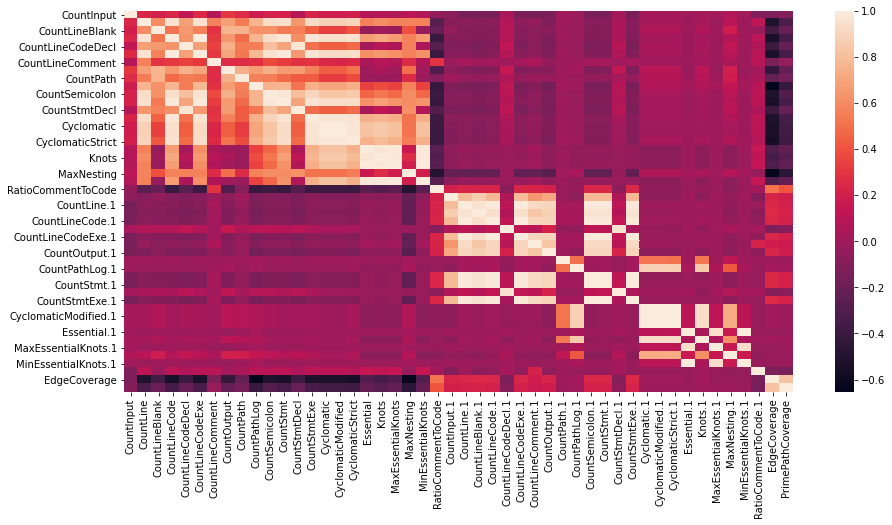

In [19]:
import seaborn as sns
plt.figure(figsize=(15,7))
sns.heatmap(dataset.corr())

## Funções uteis

In [64]:
from sklearn.preprocessing import StandardScaler
def escalonador(dados):
    scaler = StandardScaler()
    return scaler.fit_transform(dados)

def evaluate(previsores, classificador):
    k = 10
    ppc = dataset.iloc[:,-1].values#.reshape(-1,1)
    resultados = cross_val_score(classificador, previsores, ppc, cv=k)
    resultados_escalonados = cross_val_score(classificador, escalonador(previsores), ppc, cv=k)
    
    print('-----< SEM ESCALONAMENTO >-----')
    print('Precisão:', resultados.mean())
    print('Std:', resultados.std())
    print('-----< COM ESCALONAMENTO >-----')
    print('Precisão:', resultados_escalonados.mean())
    print('Std:', resultados_escalonados.std())

## Regressão linear

In [21]:
from sklearn.linear_model import LinearRegression

In [22]:
x = dataset['MaxNesting'].values.reshape(-1,1)
y = dataset.iloc[:,-1].values.reshape(-1,1)

In [23]:
# Cross validation
from sklearn.model_selection import cross_val_score
def cross_validation_reg_lin(previsores):
    classificador = LinearRegression()
    k = 10
    resultados = cross_val_score(classificador, previsores, y, cv=k)
    print('Precisão:', resultados.mean())
    print('Std:', resultados.std())

In [26]:
cross_validation_reg_lin(x)

Precisão: 0.19755409557248166
Std: 0.14978087638002763


In [27]:
cross_validation_reg_lin(dataset[['MaxNesting', 'Cyclomatic']].values)

Precisão: 0.18914178846818214
Std: 0.1453553265572905


In [28]:
cross_validation_reg_lin(dataset[['Cyclomatic']].values)

Precisão: 0.05129967330354914
Std: 0.3192023143951587


In [29]:
cross_validation_reg_lin(dataset[['MaxNesting', 'Cyclomatic', 'CountLineBlank']].values)

Precisão: 0.180923622706338
Std: 0.15155285849714864


In [30]:
cross_validation_reg_lin(dataset[['CountInput','CountLine','CountLineBlank','CountLineCode','CountLineCodeDecl','CountLineCodeExe','CountLineComment','CountOutput','CountPath','CountPathLog','CountSemicolon','CountStmt','CountStmtDecl','CountStmtExe','Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential','Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots','RatioCommentToCode','CountInput.1','CountLine.1','CountLineBlank.1','CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1','CountLineComment.1','CountOutput.1','CountPath.1','CountPathLog.1','CountSemicolon.1','CountStmt.1','CountStmtDecl.1','CountStmtExe.1','Cyclomatic.1','CyclomaticModified.1','CyclomaticStrict.1','Essential.1','Knots.1','MaxEssentialKnots.1','MaxNesting.1','MinEssentialKnots.1','RatioCommentToCode.1']].values)

Precisão: 0.0335240958372197
Std: 0.9310849429001038


## Arvore de decisão

In [31]:
from sklearn.tree import DecisionTreeRegressor
classificador = DecisionTreeRegressor()

In [32]:
evaluate(dataset[['CountInput','CountLine','CountLineBlank','CountLineCode','CountLineCodeDecl','CountLineCodeExe','CountLineComment','CountOutput','CountPath','CountPathLog','CountSemicolon','CountStmt','CountStmtDecl','CountStmtExe','Cyclomatic','CyclomaticModified','CyclomaticStrict','Essential','Knots','MaxEssentialKnots','MaxNesting','MinEssentialKnots','RatioCommentToCode','CountInput.1','CountLine.1','CountLineBlank.1','CountLineCode.1','CountLineCodeDecl.1','CountLineCodeExe.1','CountLineComment.1','CountOutput.1','CountPath.1','CountPathLog.1','CountSemicolon.1','CountStmt.1','CountStmtDecl.1','CountStmtExe.1','Cyclomatic.1','CyclomaticModified.1','CyclomaticStrict.1','Essential.1','Knots.1','MaxEssentialKnots.1','MaxNesting.1','MinEssentialKnots.1','RatioCommentToCode.1']].values, classificador)

-----< SEM ESCALONAMENTO >-----
Precisão: -0.16636106967501532
Std: 0.5069369461069951
-----< COM ESCALONAMENTO >-----
Precisão: -0.08459256984639896
Std: 0.44681871628229913


In [33]:
evaluate(dataset[['CountStmtExe', 'Cyclomatic']].values, classificador)

-----< SEM ESCALONAMENTO >-----
Precisão: 0.37125583252109384
Std: 0.22283253769825934
-----< COM ESCALONAMENTO >-----
Precisão: 0.3717620131990209
Std: 0.2317953035375583


In [34]:
evaluate(escalonador(dataset[['CountStmtExe', 'Cyclomatic', 'CountPathLog', 'MaxNesting']].values), classificador)

-----< SEM ESCALONAMENTO >-----
Precisão: 0.395964466263914
Std: 0.2303937737028732
-----< COM ESCALONAMENTO >-----
Precisão: 0.4101223438318319
Std: 0.1929198013616986


In [35]:
evaluate(escalonador(dataset[['CountStmtExe', 'Cyclomatic', 'CountPathLog']].values), classificador)

-----< SEM ESCALONAMENTO >-----
Precisão: 0.3959454582101155
Std: 0.23172697752023802
-----< COM ESCALONAMENTO >-----
Precisão: 0.39413638454554173
Std: 0.23141339512964448


## SVM

In [54]:
from sklearn.svm import SVR
classificador = SVR(kernel='poly')

In [55]:
evaluate(dataset[['CountStmtExe', 'Cyclomatic']].values, classificador)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return 

-----< SEM ESCALONAMENTO >-----
Precisão: -1.2353347954764928
Std: 3.5322836673775435
-----< COM ESCALONAMENTO >-----
Precisão: -0.7125233825470472
Std: 1.5388812222858683


In [56]:
evaluate(escalonador(dataset[['CountStmtExe', 'Cyclomatic', 'CountPathLog']].values), classificador)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return 

-----< SEM ESCALONAMENTO >-----
Precisão: -2.181756085793192
Std: 4.5247542095327695
-----< COM ESCALONAMENTO >-----
Precisão: -2.1817576908712333
Std: 4.524753998732078


In [57]:
evaluate(escalonador(dataset[['CountStmtExe', 'Cyclomatic', 'CountPathLog', 'MaxNesting']].values), classificador)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return 

-----< SEM ESCALONAMENTO >-----
Precisão: -15.12071523127969
Std: 37.15160699856289
-----< COM ESCALONAMENTO >-----
Precisão: -15.122039080341526
Std: 37.155546123707296


## Neural network models

In [41]:
from sklearn.neural_network import MLPRegressor
classificador = MLPRegressor()

In [44]:
evaluate(dataset[['CountStmtExe', 'Cyclomatic']].values, classificador)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return 

-----< SEM ESCALONAMENTO >-----
Precisão: 0.356174922669105
Std: 0.16514082077085104
-----< COM ESCALONAMENTO >-----
Precisão: 0.3524273149380183
Std: 0.16926351691069724


In [46]:
evaluate(escalonador(dataset[['CountStmtExe', 'Cyclomatic', 'CountPathLog']].values), classificador)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return 

-----< SEM ESCALONAMENTO >-----
Precisão: 0.3742751701617607
Std: 0.18221907209657215
-----< COM ESCALONAMENTO >-----
Precisão: 0.36781035153830716
Std: 0.17899476573766665


In [47]:
evaluate(escalonador(dataset[['CountStmtExe', 'Cyclomatic', 'CountPathLog', 'MaxNesting']].values), classificador)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return 

-----< SEM ESCALONAMENTO >-----
Precisão: 0.4098576402042526
Std: 0.17145765976665941
-----< COM ESCALONAMENTO >-----
Precisão: 0.41581567858353613
Std: 0.17198220491370522


## Random forest

In [58]:
from sklearn.ensemble import RandomForestRegressor
classificador = RandomForestRegressor()

In [59]:
evaluate(dataset[['CountStmtExe', 'Cyclomatic']].values, classificador)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector 

-----< SEM ESCALONAMENTO >-----
Precisão: 0.39108858696018045
Std: 0.20800758977655218
-----< COM ESCALONAMENTO >-----
Precisão: 0.3932293314641945
Std: 0.21082552763249135


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [60]:
evaluate(escalonador(dataset[['CountStmtExe', 'Cyclomatic', 'CountPathLog']].values), classificador)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector 

-----< SEM ESCALONAMENTO >-----
Precisão: 0.41522448396378386
Std: 0.20801809163938365
-----< COM ESCALONAMENTO >-----
Precisão: 0.4145736898644066
Std: 0.2052823085225537


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


In [61]:
evaluate(escalonador(dataset[['CountStmtExe', 'Cyclomatic', 'CountPathLog', 'MaxNesting']].values), classificador)

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector 

-----< SEM ESCALONAMENTO >-----
Precisão: 0.42097509371922043
Std: 0.201846066187291
-----< COM ESCALONAMENTO >-----
Precisão: 0.4231728452041879
Std: 0.19935994065744495
